In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import glob

from RNN import RNN
#from CNN import CNN
from Transformer_optimized import ConsTransformer
from Transformer import Transformer

from utils import series_to_supervised
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
dataset = pd.read_csv('new_dataset/main_data.csv', encoding='cp1252', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

# resample data to daily
#daily_groups = dataset.resample('H') , index_col=['datetime']
#daily_data = daily_groups.sum()

# We choose to keep only Global_active_power
#to_drop = ['Wind Direction (deg)','h_max','Barometric Pressure (hPa)','Sea Level Pressure (hPa)','Precipitation (mm)']
daily_data = dataset[['Solar radiation (MJ/m2)','daylight (hr)','Ground temperature (°C)','humidity','Power']]

#daily_data.drop(columns=to_drop, inplace=True)

In [3]:
daily_data = daily_data.fillna(0)

In [4]:

# add calendar-related features
daily_data['hour'] = pd.DatetimeIndex(daily_data.index).hour
daily_data['day'] = pd.DatetimeIndex(daily_data.index).day
daily_data['weekday'] = ((pd.DatetimeIndex(daily_data.index).dayofweek) // 5 == 1).astype(float)
daily_data['season'] = [month%12 // 3 + 1 for month in pd.DatetimeIndex(daily_data.index).month]

# summarize
print(daily_data.info())
#print(daily_data.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2021-01-01 00:00:00 to 2022-12-31 22:59:00
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Solar radiation (MJ/m2)  17520 non-null  float64
 1   daylight (hr)            17520 non-null  float64
 2   Ground temperature (°C)  17520 non-null  float64
 3   humidity                 17520 non-null  int64  
 4   Power                    17520 non-null  int64  
 5   hour                     17520 non-null  int64  
 6   day                      17520 non-null  int64  
 7   weekday                  17520 non-null  float64
 8   season                   17520 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 1.3 MB
None


In [5]:
look_back = 168
n_features = daily_data.shape[1]
n_features

9

In [6]:
daily_data.head()

,Solar radiation (MJ/m2),daylight (hr),Ground temperature (°C),humidity,Power,hour,day,weekday,season
datetime,,,,,,,,,
2021-01-01 00:00:00,0.0,0.0,-6.8,66,0,0,1,0.0,1
2021-01-01 01:00:00,0.0,0.0,-6.9,68,0,1,1,0.0,1
2021-01-01 02:00:00,0.0,0.0,-7.1,69,0,2,1,0.0,1
2021-01-01 03:00:00,0.0,0.0,-7.3,70,0,3,1,0.0,1
2021-01-01 04:00:00,0.0,0.0,-7.5,71,0,4,1,0.0,1


In [7]:

# Walk-forward data split to avoid data leakage
X_train, y_train, X_test, y_test, scale_X = series_to_supervised(daily_data, train_size=0.8, n_in=look_back, n_out=24, target_column='Power', dropnan=True, scale_X=True)

# reshape input to be 3D [samples, timesteps, features]
X_train_reshaped = X_train.values.reshape((-1,look_back,n_features))
X_test_reshaped = X_test.values.reshape((-1,look_back,n_features))

y_train_reshaped = y_train.values
y_test_reshaped = y_test.values

In [8]:
X_train_reshaped.shape

(13863, 168, 9)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 168, 9)]     0                                            
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 168, 9)       18          input_1[0][0]                    
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 168, 9)       39945       layer_normalization[0][0]        
                                                                 layer_normalization[0][0]        
__________________________________________________________________________________________________
dropout (Dropout)               (None, 168, 9)       0           multi_head_attention[0][0]   

Epoch 1/600
174/174 [==============================] - 36s 133ms/step - loss: 677.6022 - rmse: 25.9806 - mae: 15.9948 - smape: nan - coeff_determination: -0.2754 - val_loss: 674.2511 - val_rmse: 25.1620 - val_mae: 19.9150 - val_smape: nan - val_coeff_determination: -0.1302

Epoch 00001: loss improved from inf to 624.54852, saving model to checkpoint\Transformer.best06122022_235511.hdf5
Epoch 2/600
174/174 [==============================] - 16s 91ms/step - loss: 564.6768 - rmse: 23.7440 - mae: 17.7422 - smape: nan - coeff_determination: -0.0614 - val_loss: 643.3393 - val_rmse: 24.7227 - val_mae: 20.6503 - val_smape: 67.0765 - val_coeff_determination: -0.1210

Epoch 00002: loss improved from 624.54852 to 556.09601, saving model to checkpoint\Transformer.best06122022_235511.hdf5
Epoch 3/600
174/174 [==============================] - 16s 95ms/step - loss: 544.5301 - rmse: 23.3162 - mae: 17.8719 - smape: nan - coeff_determination: -0.0204 - val_loss: 596.6653 - val_rmse: 23.8518 - val_mae: 

Epoch 22/600
174/174 [==============================] - 14s 83ms/step - loss: 128.1351 - rmse: 11.3003 - mae: 6.0862 - smape: nan - coeff_determination: 0.7558 - val_loss: 178.6523 - val_rmse: 12.9818 - val_mae: 8.1257 - val_smape: nan - val_coeff_determination: 0.5836

Epoch 00022: loss improved from 129.95557 to 128.17299, saving model to checkpoint\Transformer.best06122022_235511.hdf5
Epoch 23/600
174/174 [==============================] - 16s 83ms/step - loss: 129.2972 - rmse: 11.3521 - mae: 6.1099 - smape: nan - coeff_determination: 0.7547 - val_loss: 181.6164 - val_rmse: 12.9878 - val_mae: 8.5292 - val_smape: nan - val_coeff_determination: 0.5357

Epoch 00023: loss improved from 128.17299 to 128.09515, saving model to checkpoint\Transformer.best06122022_235511.hdf5
Epoch 24/600
174/174 [==============================] - 15s 84ms/step - loss: 125.1026 - rmse: 11.1659 - mae: 5.9887 - smape: nan - coeff_determination: 0.7618 - val_loss: 169.1828 - val_rmse: 12.5373 - val_mae: 7.9964


Epoch 00043: loss did not improve from 112.43403
Epoch 44/600
174/174 [==============================] - 16s 91ms/step - loss: 112.2374 - rmse: 10.5761 - mae: 5.6179 - smape: nan - coeff_determination: 0.7875 - val_loss: 204.7027 - val_rmse: 13.8390 - val_mae: 9.5720 - val_smape: nan - val_coeff_determination: 0.4783

Epoch 00044: loss improved from 112.43403 to 111.78822, saving model to checkpoint\Transformer.best06122022_235511.hdf5
Epoch 45/600
174/174 [==============================] - 16s 91ms/step - loss: 111.1840 - rmse: 10.5281 - mae: 5.5975 - smape: nan - coeff_determination: 0.7889 - val_loss: 190.3882 - val_rmse: 13.3875 - val_mae: 8.8570 - val_smape: nan - val_coeff_determination: 0.5479

Epoch 00045: loss improved from 111.78822 to 111.68446, saving model to checkpoint\Transformer.best06122022_235511.hdf5
Epoch 46/600
174/174 [==============================] - 18s 103ms/step - loss: 109.9946 - rmse: 10.4616 - mae: 5.5406 - smape: nan - coeff_determination: 0.7906 - val_l

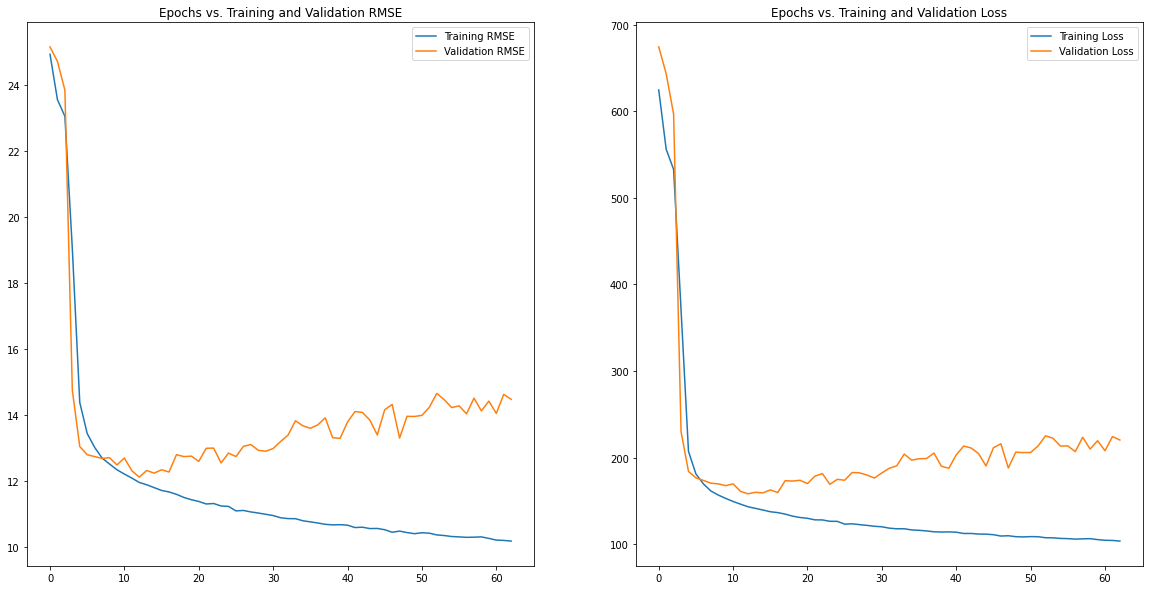

In [9]:

## Testing the Transformer
tr = Transformer()
tr.train(X_train_reshaped,y_train_reshaped)


In [39]:
model, rmse_result, mae_result, smape_result, r2_result = tr.evaluate(X_test_reshaped,y_test_reshaped)


print('Result \n RMSE = %.2f [kWh] \n MAE = %.2f [kWh]\n R2 = %.1f [%%]' % (rmse_result,
                                                                            mae_result,
                                                                            r2_result*100))

109/109 [==============================] - 1s 11ms/step - loss: 179.6789 - rmse: 12.3560 - mae: 7.1691 - smape: nan - coeff_determination: 0.1455
Result 
 RMSE = 12.36 [kWh] 
 MAE = 7.17 [kWh]
 R2 = 64.9 [%]


Trial 3 Complete [00h 05m 20s]
val_loss: 197.8472671508789

Best val_loss So Far: 195.8955307006836
Total elapsed time: 00h 16m 52s
INFO:tensorflow:Oracle triggered exit
Search space summary
Default search space size: 1
mlp_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 16, 'sampling': None}
None
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 168, 9)]     0                                            
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 168, 9)       18          input_1[0][0]                    
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 168, 9)    

Epoch 1/600
174/174 [==============================] - 25s 95ms/step - loss: 127.4882 - rmse: 11.2743 - mae: 6.1378 - smape: nan - coeff_determination: 0.7585 - val_loss: 169.9144 - val_rmse: 12.6338 - val_mae: 7.5164 - val_smape: nan - val_coeff_determination: 0.4812

Epoch 00001: loss improved from inf to 127.24406, saving model to checkpoint\Transformer.best07122022_003101.hdf5
Epoch 2/600
174/174 [==============================] - 16s 91ms/step - loss: 126.2675 - rmse: 11.2186 - mae: 6.1093 - smape: nan - coeff_determination: 0.7587 - val_loss: 169.7742 - val_rmse: 12.6370 - val_mae: 7.5923 - val_smape: nan - val_coeff_determination: 0.4859

Epoch 00002: loss improved from 127.24406 to 125.51892, saving model to checkpoint\Transformer.best07122022_003101.hdf5
Epoch 3/600
174/174 [==============================] - 15s 88ms/step - loss: 122.1463 - rmse: 11.0349 - mae: 5.9896 - smape: nan - coeff_determination: 0.7653 - val_loss: 167.1145 - val_rmse: 12.6288 - val_mae: 7.6966 - val_sm

174/174 [==============================] - 17s 100ms/step - loss: 101.8052 - rmse: 10.0694 - mae: 5.3381 - smape: nan - coeff_determination: 0.8062 - val_loss: 243.6090 - val_rmse: 15.0517 - val_mae: 9.8716 - val_smape: nan - val_coeff_determination: 0.4902

Epoch 00022: loss improved from 100.14953 to 99.69112, saving model to checkpoint\Transformer.best07122022_003101.hdf5
Epoch 23/600
174/174 [==============================] - 16s 93ms/step - loss: 96.8178 - rmse: 9.8239 - mae: 5.2114 - smape: nan - coeff_determination: 0.8163 - val_loss: 239.0346 - val_rmse: 14.8753 - val_mae: 9.4884 - val_smape: nan - val_coeff_determination: 0.5150

Epoch 00023: loss improved from 99.69112 to 98.75118, saving model to checkpoint\Transformer.best07122022_003101.hdf5
Epoch 24/600
174/174 [==============================] - 16s 91ms/step - loss: 98.9255 - rmse: 9.9267 - mae: 5.2759 - smape: nan - coeff_determination: 0.8115 - val_loss: 239.4251 - val_rmse: 14.8837 - val_mae: 9.4964 - val_smape: nan -

174/174 [==============================] - 16s 92ms/step - loss: 88.5666 - rmse: 9.3918 - mae: 4.9725 - smape: nan - coeff_determination: 0.8308 - val_loss: 247.6715 - val_rmse: 14.9419 - val_mae: 9.0840 - val_smape: nan - val_coeff_determination: 0.4532

Epoch 00044: loss did not improve from 89.29626
Epoch 45/600
174/174 [==============================] - 16s 92ms/step - loss: 87.8070 - rmse: 9.3553 - mae: 4.9402 - smape: nan - coeff_determination: 0.8312 - val_loss: 253.9697 - val_rmse: 15.1080 - val_mae: 9.2227 - val_smape: nan - val_coeff_determination: 0.4548

Epoch 00045: loss improved from 89.29626 to 89.19516, saving model to checkpoint\Transformer.best07122022_003101.hdf5
Epoch 46/600
174/174 [==============================] - 14s 83ms/step - loss: 86.6466 - rmse: 9.2892 - mae: 4.9109 - smape: nan - coeff_determination: 0.8362 - val_loss: 267.4671 - val_rmse: 15.5201 - val_mae: 9.6346 - val_smape: nan - val_coeff_determination: 0.4150

Epoch 00046: loss improved from 89.19516

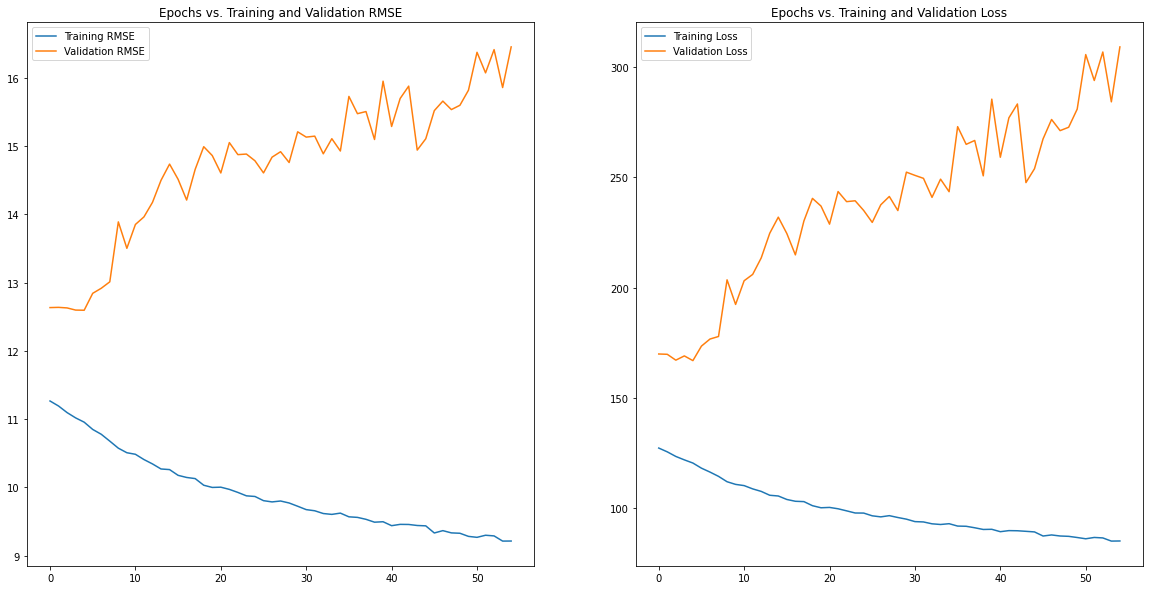

In [11]:

## Testing the Constained Transformer
tr_adv = ConsTransformer()
tr_adv.train_advance(X_train_reshaped,y_train_reshaped)


In [38]:
model_2, rmse_result_2, mae_result_2, smape_result_2, r2_result_2 = tr_adv.evaluate(X_test_reshaped,y_test_reshaped)


print('Result \n RMSE = %.2f [kWh] \n MAE = %.2f [kWh]\n R2 = %.1f [%%]' % (rmse_result_2,
                                                                            mae_result_2,
                                                                            r2_result_2*100))

109/109 [==============================] - 1s 11ms/step - loss: 151.4801 - rmse: 11.6029 - mae: 6.7027 - smape: nan - coeff_determination: 0.3073
Result 
 RMSE = 11.60 [kWh] 
 MAE = 6.70 [kWh]
 R2 = 70.4 [%]


In [24]:
a = model_2.predict(X_test.values.reshape(-1,168,9))[9]

In [28]:
a_ = model.predict(X_test.values.reshape(-1,168,9))[9]

In [25]:
b = y_test.values[9]

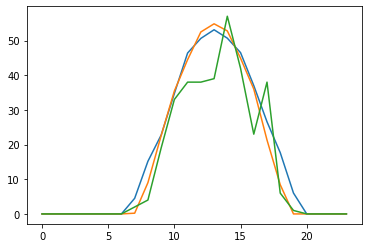

In [29]:
import matplotlib.pyplot as plt
plt.plot(a_)
plt.plot(a)
plt.plot(b)

In [36]:
X_test_reshaped[154:].shape

(3312, 168, 9)

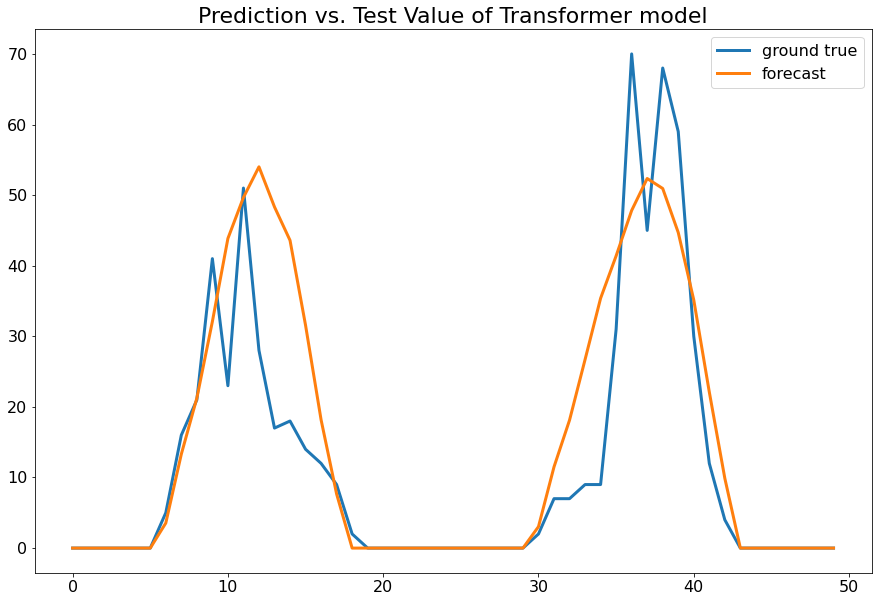

In [35]:
trueval = y_test.values
forecast = model_2.predict(X_test_reshaped)
plt.figure(figsize=(15,10))
plt.plot(trueval[154:204,0],linewidth=3,label='ground true')
plt.plot(forecast[154:204,0],linewidth=3,label='forecast')
plt.title('Prediction vs. Test Value of Transformer model',fontsize=22)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)